<a href="https://colab.research.google.com/github/aguschanchu/FermionicML/blob/main/FermionicML_thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FermionicML:

Code based on aguschanchu/Bosonic.py

A diferencia del código anterior, este modelo trabaja sobre estados térmicos

## Código base

Cargamos el código de Bosonic.py básico, branch fermionic

In [2]:
import numpy as np
from scipy.special import binom
from scipy.sparse import dok_matrix, linalg
from scipy import linalg as linalg_d
from joblib import Memory
import random
import plotly.graph_objects as go
from joblib import Parallel, delayed
from numba import jit, prange, njit
import numba as nb
import pickle
import math
import tensorflow_probability as tfp

# Funciones auxiliares optimiadas
@nb.jit(nopython=True, parallel=True)
def int_to_tuple_arr(ni,nf, b, digits=None):
    sol = np.zeros((nf-ni, digits), dtype=np.int64)
    for n in prange(ni, nf):
        r = np.zeros(digits, dtype=np.int64)
        ncop = n
        idx = 0
        while n != 0:
            r[idx] = n % b
            n = n // b
            idx += 1
        if digits is not None:
            if idx < digits:
                for i in range(idx, digits):
                    r[i] = 0
                idx = digits
        sol[ncop-ni,:] = r[:idx]
    return sol

def tuple_to_int(t, d):
    b = d-1
    l = len(t)
    s = [t[k]*b**(l-k-1) for k in range(0,l)]
    return sum(s)

def create_basis_(m, d, size):
    base = []
    index = 0
    chunk_size = 1000000
    for x in range(0,(m+1)**d, chunk_size):
        start_index = x
        end_index = min(x + chunk_size, (m+1)**d)
        arr = int_to_tuple_arr(start_index, end_index, m+1, d)
        sums = np.sum(arr, axis=1)
        rows = np.where(sums == m)[0]
        for row in [arr[i] for i in rows]:
            if np.all(np.logical_or(row == 0, row == 1)):
                base.append(row)

    # Como consecuencia de la paralelizacion, es necesario reordenar la base
    sorted_base = sorted(base, key=lambda x: tuple_to_int(x, d), reverse=True)
    assert len(base) == size

    return base

class fixed_basis:

    # Convierte a un enterno n a su escritura en base b
    def _int_to_tuple(self, n, b, digits = None):
        rep = np.base_repr(n, b)
        rep_int = [int(x,b) for x in rep]
        if digits is not None:
            zeros = [0 for i in range(0,digits-len(rep))]
            return zeros + rep_int
        else:
            return rep_int

    # Revierte la transformacion anterior
    def tuple_to_int(self, t):
        b = self.d-1
        l = len(t)
        s = [t[k]*b**(l-k-1) for k in range(0,l)]
        return sum(s)

    # Convierte el vector en su representacion
    def vect_to_repr(self, vect):
        for i, k in enumerate(vect):
            if k == 1. or k == 1:
                break
        else:
            return 0
        return self.base[i,:]

    def rep_to_vect(self, rep):
        rep = list(rep)
        for i, r in [(j, self.base[j,:]) for j in range(0,self.size)]:
            if list(r) == rep:
                return self.canonicals[:,i]
        else:
            None

    def rep_to_index(self, rep):
        return self.base.tolist().index(list(rep))

    @staticmethod
    def rep_to_exi(rep):
        r = []
        for i, k in enumerate(rep):
            r += [i for x in range(0,k)]
        return r

    # Crea base de M particulas en D estados (repr y base canonica)
    def create_basis(self, m, d):
        #print("Creating basis: ", m, d)
        length = int(binom(d,m))
        base = np.array(create_basis_(m, d, length))
        # Asignamos a cada uno de ellos un canónico
        canonicals = np.eye(length)
        return base, canonicals

    def __init__(self, m, d):
        self.m = m
        self.d = d
        self.size = int(binom(d,m))
        (self.base, self.canonicals) = self.create_basis(m, d)


# Matrices de aniquilación y creación endomórficas. Estan fuera de la clase para poder ser cacheadas
#@memory.cache
def bdb(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[j] != 0 and v[i] != 1:
                dest = list(v.copy())
                dest[j] -= 1
                dest[i] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[i]+1)*np.sqrt(v[j])
    else:
        for k, v in enumerate(basis.base):
            if v[j] != 0:
                mat[k, k] = v[i]
    return mat

#@memory.cache
def bbd(basis, i, j):
    mat = dok_matrix((basis.size, basis.size), dtype=np.float32)
    if i != j:
        for k, v in enumerate(basis.base):
            if v[i] != 0 and v[j] != 1:
                dest = list(v.copy())
                dest[i] -= 1
                dest[j] += 1
                tar = basis.rep_to_index(dest)
                mat[tar, k] = np.sqrt(v[j]+1)*np.sqrt(v[i])
    else:
        for k, v in enumerate(basis.base):
            if v[i] != 1:
                mat[k, k] = v[i]+1
    return mat

# Matrices de aniquilación y creación.Toman la base de origen y destino (basis_o, basis_d) resp
#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def b_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 0:
            dest = list(basis_o[k].copy())
            dest[i] -= 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i])
    return mat

def b(basis_o, basis_d, i):
    return b_aux(basis_o.base, basis_d.base, i)

#@nb.jit(nopython=True, parallel=True)
@nb.jit(nopython=True)
def bd_aux(basis_o, basis_d, i):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        if basis_o[k][i] != 1:
            dest = list(basis_o[k].copy())
            dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd(basis_o, basis_d, i):
    return bd_aux(basis_o.base, basis_d.base, i)


# Acepta una lista de indices a crear
@nb.jit(nopython=True, parallel=True)
def bd_gen_aux(basis_o, basis_d, gen_list):
    mat = np.zeros((len(basis_d), len(basis_o)), dtype=np.float32)
    for k in prange(len(basis_o)):
        conds = np.zeros(len(gen_list), dtype=np.int64)
        for i in range(len(gen_list)):
            if basis_o[k][gen_list[i]] != 1:
                conds[i] = 1
        if np.all(conds):
            dest = list(basis_o[k].copy())
            for i in gen_list:
                dest[i] += 1
            for j in prange(len(basis_d)):
                if list(basis_d[j]) == dest:
                    tar = j
                    mat[tar, k] = np.sqrt(basis_o[k][i]+1)
    return mat

def bd_gen(basis_o, basis_d, i):
    return bd_gen_aux(basis_o.base, basis_d.base, np.array(i))

def b_gen(basis_o, basis_d, i):
    return np.transpose(bd_gen(basis_d, basis_o, i))

# Volvemos a definir la función para compilarla
@nb.jit(forceobj=True)
def _rep_to_index(base, rep):
    return base.tolist().index(list(rep))

# Funciones auxiliares para calcular rho2kkbar y gamma_p
@nb.jit(nopython=True)
def rep_to_exi(rep):
    r = []
    for i in range(len(rep)):
        for j in range(rep[i]):
            r.append(i)
    return r

@nb.njit
def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

@nb.njit
def gamma_lamba(x):
    res = 1.0
    for o in x:
        res *= math.sqrt(factorial(o))
    return res

@nb.jit
def gamma_lamba_inv(x):
    res = 1.0
    for o in x:
        res *= 1.0 / np.sqrt(factorial(o))
    return res

@nb.njit
def rep_to_index_np(base, rep):
    for i in range(len(base)):
        if np.all(base[i] == rep):
            return i
    return -1


def gamma_p(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    return gamma_p_aux(basis.base, vect, m_basis.base, nm_basis.base)

@nb.njit()
def gamma_p_aux(basis, vect, m_basis, nm_basis):
    mat = np.zeros((len(m_basis), len(nm_basis)), dtype=np.float32)
    for i in prange(len(m_basis)):
        v = m_basis[i]
        for j in prange(len(nm_basis)):
            w = nm_basis[j]
            targ = v + w
            index = rep_to_index_np(basis, targ)
            if index != -1:
                coef = vect[index]
                if coef != 0:
                    coef = coef * gamma_lamba_inv(v) * gamma_lamba_inv(w) * gamma_lamba(targ)
                mat[i, j] = coef
    return mat
# Devuelve la matriz rho M asociada al vector
def rho_m(basis, m, vect, m_basis = None, nm_basis = None):
    g = gamma_p(basis, m, vect, m_basis, nm_basis)
    return np.dot(g,np.transpose(g))

# Devuelve la matriz gamma asociada a la descomposición (M,N-M) del vector
@jit(forceobj=True)
def gamma(basis, m, vect, m_basis = None, nm_basis = None):
    d = basis.d
    if not m_basis or not nm_basis:
        m_basis = fixed_basis(m, d)
        nm_basis = fixed_basis(basis.m-m,d)
    mat = dok_matrix((m_basis.size, nm_basis.size), dtype=np.float32)
    for i, v in enumerate(m_basis.base):
        for j, w in enumerate(nm_basis.base):
            targ = v+w
            # Revisamos que sea un estado fermionico valido
            arr = np.asarray(targ)
            if not np.all(np.logical_or(arr == 0, arr == 1)):
                continue
            index = _rep_to_index(basis.base, targ)
            coef = vect[index]
            if coef != 0:
                aux = lambda x: np.prod(np.reciprocal(np.sqrt([np.math.factorial(o) for o in x])))
                aux_inv = lambda x: np.prod(np.sqrt([np.math.factorial(o) for o in x]))
                coef = coef * aux(v) * aux(w) * aux_inv(targ)
                #coef = coef
                #print(v,w,coef)
            mat[i,j] = coef
    return mat

# Genera las matrices de rho1
def rho_1_gen(basis):
    d = basis.d
    s = basis.size
    mat = np.empty((d,d,s,s), dtype=np.float32)
    for i in range(0, d):
        for j in range(0, d):
            mat[i,j,:,:] = np.array(bdb(basis,j, i).todense())
    return mat

#@jit(parallel=True, nopython=True)
def rho_1(d, state, rho_1_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_1_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat


# Genera las matrices de rho2
def rho_2_gen(basis, mll_basis, t_basis):
    size = t_basis.size
    s = basis.size
    # La entrada i, j contiene C_j^\dag C_i    i, j \in t_basis
    mat = np.empty((size, size, s, s), dtype=np.float32)
    for i, v in enumerate(t_basis.base):
        for j, w in enumerate(t_basis.base):
            c_i = b_gen(basis, mll_basis, rep_to_exi(v))
            cdag_j = bd_gen(mll_basis, basis, rep_to_exi(w))
            mat[i, j, :, :] = np.dot(cdag_j, c_i)

    return mat

def rho_2(size, state, rho_2_arrays):
    state_expanded = state[np.newaxis, np.newaxis, :, :]
    product = state_expanded * rho_2_arrays
    mat = np.sum(product, axis=(-2, -1))

    return mat

# Devuelve la matriz rho 2 asociada al bloque kkbar
def rho_2_kkbar(basis, vect, ml_basis = None, mll_basis = None, t_basis = None):
    d = basis.d
    # Creo las bases si no están dadas
    if ml_basis == None or mll_basis == None or t_basis == None:
        ml_basis = fixed_basis(m-1,d)
        mll_basis = fixed_basis(m-2,d)
        t_basis = fixed_basis(2,d)
    diag = []
    for v in t_basis.base:
        for j in range(0, d, 2):
            if v[j] == v[j+1]:
                continue
            else:
                break
        else:
            diag.append(v)
    diag = np.array(diag)
    return rho_2_kkbar_aux(diag, vect, basis.base, ml_basis.base, mll_basis.base, t_basis.base)

@nb.njit
def rho_2_kkbar_lambda(x):
    res = 1.0
    for o in x:
        res *= 1.0 / math.sqrt(factorial(o))
    return res

@nb.njit(parallel=True)
def rho_2_kkbar_aux(diag, vect, basis, ml_basis, mll_basis, t_basis):
    mat = np.zeros((len(diag), len(diag)), dtype=np.float32)
    for i in prange(len(diag)):
        for j in prange(len(diag)):
            v = diag[i]
            w = diag[j]
            # Creacion de los a
            i_set = rep_to_exi(v)
            b_m = b_aux(ml_basis, mll_basis, i_set[1]) @ b_aux(basis, ml_basis, i_set[0])
            # Creacion de los ad
            i_set = rep_to_exi(w)
            bd_m = bd_aux(ml_basis, basis, i_set[1]) @ bd_aux(mll_basis, ml_basis, i_set[0])
            v1 = bd_m @ b_m @ vect
            # Mult de b's y filleo de mat
            coef = vect @ v1
            rho_2_kkbar_lambda(v)
            mat[i,j] = coef * rho_2_kkbar_lambda(v) * rho_2_kkbar_lambda(w)
    return mat


/var/tmp/ipykernel_75040/2171788955.py:248: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def gamma_lamba_inv(x):


## Definicion de Hamiltoniano

Cargamos el código de creación y resolución de Hamiltonianos

In [3]:
m = 3
d = 5
# Creo las bases para no tener que recrearlas luego
basis = fixed_basis(m, d)
basis_m1 = fixed_basis(m-1, d)
basis_m2 = fixed_basis(m-2, d)
#print(basis.base)
print(basis.size)

10


In [4]:
## Usamos este approach si queremos guardar los generadores
# Dados 1/2 (d^2+d) elementos, genera una mat de dxd:
def sym_mat_gen(vect, d):
    matrix = fill_matrix(vect, d)
    return matrix + matrix.T - np.diag(matrix.diagonal())

@jit(nopython=True)
def fill_matrix(vect, d):
    matrix = np.zeros((d, d))
    idx = 0
    for i in prange(d):
        for j in prange(i, d):
            matrix[i, j] = vect[idx]
            idx += 1
    return matrix

# Generamos una matrix aleatoria. Cuidado con la distribución, ver https://stackoverflow.com/questions/56605189/is-there-an-efficient-way-to-generate-a-symmetric-random-matrix
def hamil_base_gen(d):
    U = np.random.uniform(low=0, high=1.0, size=(d, d))
    hamil_base = np.tril(U) + np.tril(U, -1).T
    return hamil_base

# Dada un a mat dxd simetrica, contruye el hamiltoniano de un cuerpo a_{ij} c^{dag}_i c_j
# Alternativamente podemos construirlo a partir de rho_1_gen
def base_hamiltonian_aux(mat, size, d, rho_1_gen):
    # Construccion de H
    rho_1_gen_transposed = rho_1_gen.transpose(1, 0, 2, 3)
    mat_expanded = mat[:, :, np.newaxis, np.newaxis]
    h = np.sum(mat_expanded * rho_1_gen_transposed[:, :, :, :], axis=(0, 1))
    return h.astype(np.float32)

def base_hamiltonian(mat, basis, rho_1_gen):
    return base_hamiltonian_aux(mat, basis.size, basis.d, rho_1_gen)

def solve(h, last_step = None):
    sol = linalg.eigsh(h, which='SA',k=19)
    eigenspace_tol = 0.0001
    if type(last_step) != type(None):
        # Seleccionamos todos los autovects que difieren sus autovalores menos que tol (mismo autoespacio)
        # y tomamos la proyección en el autoespacio de la solución del paso anterior (last_step)
        eig = sol[0].real
        eigv = sol[1]
        cand = [eigv[:,i].real  for (i, x) in enumerate(eig) if abs(x-min(eig)) < eigenspace_tol]
        cand_norm = [x/np.linalg.norm(x) for x in cand]
        fund = np.zeros(len(cand[0]))
        for x in cand_norm:
            fund += np.dot(last_step,x) * x
    else:
        argmin = np.argmin(sol[0].real)
        fund = sol[1][:,argmin]
    fund = fund.real / np.linalg.norm(fund)
    return fund

## Modelo de ML
Basado en matrices densidad de 1 y 2 cuerpos como input, con hamiltoniano como salida

In [5]:
import tensorflow as tf
import numpy as np
tf.test.gpu_device_name()

2023-10-04 17:08:21.317041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 17:08:21.320233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 17:08:21.322918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'/device:GPU:0'

In [6]:
# Construccion de bases para calculo de rho1 y rho2
# rho2
m = 2
m2_basis = fixed_basis(m, d)
print(m2_basis.size)
nm2_basis = fixed_basis(basis.m-m, d)
print(nm2_basis.base)
# rho1
m = 1
m1_basis = fixed_basis(m, d)
print(m1_basis.size)
nm1_basis = fixed_basis(basis.m-m, d)

10
[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
5


### Algunos benchmarks y funciones auxiliares

In [7]:
# Given h calculo en rho2 y rho1 máximo
def rho1_rho2(h, beta):
    fund = thermal_state(h, beta)
    rho2 = np.array(rho_2(basis, m2_basis.size, state, rho_2_arrays))
    r = np.sort(linalg_d.eigvals(rho2).real)
    rho_2_max = r[0]
    rho1 = np.array(rho_1(basis, state, rho_1_arrays))
    r = np.sort(linalg_d.eigvals(rho1).real)
    rho_1_max = r[0]

    return (rho_1_max, rho_2_max)

def fill_triangular_np(x):
    m = x.shape[0]
    n = np.int32(np.sqrt(.25 + 2 * m) - .5)
    x_tail = x[(m - (n**2 - m)):]
    return np.triu(np.concatenate([x, x_tail[::-1]], 0).reshape(n, n))


In [8]:
# Dado h, \beta, construyo el estado térmico
from scipy.linalg import expm

def thermal_state(h, beta):
    quotient = expm(-beta*h)
    return quotient / np.trace(quotient)

## NO usar para mat no hermiticas
@nb.jit(nopython=True)
def thermal_state_eig(h, beta):
    w, v = np.linalg.eigh(-beta*h)
    D = np.diag(np.exp(w))
    mat = v @ D @ v.T
    mat = mat / np.trace(mat)
    return mat
    
def gen_to_h(base, rho_1_arrays):
    triag = fill_triangular_np(base)
    body_gen = triag + np.transpose(triag)-np.diag(np.diag(triag))
    h = np.array(base_hamiltonian(body_gen, basis, rho_1_arrays))  
    return h 

def gen_to_h_tf(hamil_base, rho_1_arrays):
    triag = tfp.math.fill_triangular(hamil_base, upper=True)
    body_gen = triag + tf.transpose(triag, perm=[0,2,1])-tf.linalg.diag(tf.linalg.diag_part(triag)) # Simetrizamos y generamos la matriz de h
    hamil_expanded = body_gen[:, :, :, np.newaxis, np.newaxis]
    rho_1_gen_transposed = tf.transpose(rho_1_arrays, perm=[1, 0, 2, 3])
    h_arr = tf.reduce_sum(hamil_expanded * rho_1_gen_transposed[np.newaxis,:,:,:,:], axis=[1,2])
    return h_arr

def thermal_state_tf(h):
    # Assume beta=1
    exp_hamiltonian = tf.linalg.expm(-h)
    partition_function = tf.linalg.trace(exp_hamiltonian)
    partition_function = tf.expand_dims(partition_function, axis=1)
    partition_function = tf.expand_dims(partition_function, axis=1)
    
    rho = exp_hamiltonian / partition_function

    return rho

def rho_1_tf(state, rho_1_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_1_arrays_expanded = tf.expand_dims(rho_1_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_1_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

def rho_2_tf(state, rho_2_arrays):
    state = tf.expand_dims(state, axis=1)  # Shape: (5120, 10, 1, 10)
    state_expanded = tf.expand_dims(state, axis=1)
    rho_2_arrays_expanded = tf.expand_dims(rho_2_arrays, axis=0)  # Shape: (1, 5, 5, 10, 10)
    product = state_expanded * rho_2_arrays_expanded  # Shape: (5120, 10, 5, 10, 10)
    mat = tf.reduce_sum(product, axis=[-2, -1])  # Shape: (5120, 5, 5)
    
    return mat

### Construccion de dataset

#### Version sincrónica

In [53]:
import time
from tqdm import tqdm
# Config
num_samples = 2000000
use_gpu = True
gpu_batch_size = 1024*4

# Construccion de parametros y matrices auxiliares
rho1_size = m1_basis.size
rho2_size = m2_basis.size
fund_size = basis.size
hamil_base_size = basis.d*(basis.d+1)//2
rho_1_arrays = rho_1_gen(basis)
rho_1_arrays_tf = tf.constant(rho_1_arrays, dtype=tf.float32)
rho_2_arrays = rho_2_gen(basis, nm2_basis, m2_basis)
rho_2_arrays_tf = tf.constant(rho_2_arrays, dtype=tf.float32)


if use_gpu:
    print(tf.test.gpu_device_name())
    datasets = []
    for i in tqdm(range(num_samples//gpu_batch_size+1)):
        size = basis.d*(basis.d+1)//2
        h_labels = [np.random.uniform(low=0, high=1.0, size=(size,)) for _ in range(0,gpu_batch_size)] # Generamos los generadores
        hamil_base = tf.constant(h_labels, dtype=tf.float32)
        h_arr = gen_to_h_tf(hamil_base, rho_1_arrays_tf)
        state = thermal_state_tf(h_arr)
        rho_1_input = rho_1_tf(state, rho_1_arrays_tf)
        rho_2_input = rho_2_tf(state, rho_2_arrays_tf)

        
        datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels)))
        #datasets.append(tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, state), h_labels)))
    ds = tf.data.Dataset.from_tensor_slices(datasets)
    dataset = ds.interleave(
        lambda x: x,
        cycle_length=1,
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    
else:
    rho_1_input = []
    rho_2_input = []
    fund_input = []
    beta_input = []
    h_labels = []
    hamil_base = []

    time_hamil = 0
    time_thermal = 0
    time_rho1 = 0
    time_rho2 = 0

    tt = time.time()

    # Construccion de hamiltonianos
    print("Hamiltonian array generation in progress...")
    t0 = time.time()
    h_arr = []
    for i in tqdm(range(num_samples)):
        size = basis.d*(basis.d+1)//2
        base = np.random.uniform(low=0, high=1.0, size=(size,))
        h = gen_to_h(base, rho_1_arrays)
        hamil_base.append(base)
        h_arr.append(h)
    time_hamil = time.time() - t0

    for i in tqdm(range(num_samples)):
        t0 = time.time()
        h = h_arr[i]
        # Guardamos el label
        h_labels.append(hamil_base[i])
        #beta = np.random.random()*10+0.0001
        beta = 1
        state = thermal_state_eig(h, beta)
        fund_input.append(state)
        beta_input.append(beta)
        time_thermal += time.time() - t0
        #print(state.shape)
        t0 = time.time()
        # Calculamos las matrices de 1 y 2 cuerpos
        rho1 = np.array(rho_1(d, state, rho_1_arrays))
        time_rho1 += time.time() - t0

        t0 = time.time()
        #print(rho1)
        rho2 = np.array(rho_2(m2_basis.size, state, rho_2_arrays))
        #print(rho2)
        rho_2_input.append(rho2)
        rho_1_input.append(rho1)
        time_rho2 += time.time() - t0

    print(time.time()-tt)
    t0 = time.time()
    # Sin fundamental
    dataset = tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input), h_labels))
    # Con fundamental
    #dataset = tf.data.Dataset.from_tensor_slices(((rho_1_input, rho_2_input, fund_input), h_labels))
    time_data = time.time() - t0

    print(time_hamil, time_thermal, time_rho1, time_rho2, time_data)

#batch_size = 32
#dataset = dataset.shuffle(buffer_size=num_samples).batch(batch_size)

2023-10-04 17:31:07.322611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 17:31:07.324721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 17:31:07.326489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

/device:GPU:0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:58<00:00,  8.30it/s]


#### Version asincróncica (WIP)

In [10]:
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Define a function to process a single sample
def process_sample(h):
    beta = 1  # Or use your random beta calculation here
    state = thermal_state_eig(h, beta)

    rho1 = np.array(rho_1(d, state, rho_1_arrays))

    rho2 = np.array(rho_2(m2_basis.size, state, rho_2_arrays))

# Number of concurrent processes
num_processes = 16  # Adjust this based on your CPU's capabilities

"""
# Create a ProcessPoolExecutor
with ProcessPoolExecutor(max_workers=num_processes) as executor:
    # Process samples in parallel using the executor
    futures = [executor.submit(process_sample, h_arr[i]) for i in tqdm(range(num_samples))]

# Wait for all futures to complete
for future in futures:
    future.result()
"""

'\n# Create a ProcessPoolExecutor\nwith ProcessPoolExecutor(max_workers=num_processes) as executor:\n    # Process samples in parallel using the executor\n    futures = [executor.submit(process_sample, h_arr[i]) for i in tqdm(range(num_samples))]\n\n# Wait for all futures to complete\nfor future in futures:\n    future.result()\n'

#### Filleo de dataset

In [11]:
import pickle
# Save and load dataset
save_dataset = False
load_dataset = False
path = "/home/agus/TF"
#num_samples = 5000000
if save_dataset:
    tf.data.Dataset.save(dataset, path)
    with open("/home/agus/"+'/file.pkl', 'wb') as file:
        pickle.dump(beta_input, file)
if load_dataset:
    dataset = tf.data.Dataset.load(path)
    with open("/home/agus/"+'file.pkl', 'rb') as file:
        beta_input = pickle.load(file)


In [54]:
# Dividimos los datasets
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


batch_size = 1024*5
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

#beta_val = beta_input[train_size:]

In [39]:
# Cardinality no funciona con los datasets generados por GPU
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
print("Validation Dataset Size:", val_size)


Validation Dataset Size: -2


### Definición de modelo

In [14]:
# Modelo denso + fundamental
rho1_layer =  tf.keras.layers.Input(shape=(rho1_size,rho1_size, 1), name='rho1')
flatten_rho1 = tf.keras.layers.Flatten()(rho1_layer)
rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')
flatten_rho2 = tf.keras.layers.Flatten()(rho2_layer)
#fund_layer =  tf.keras.layers.Input(shape=(fund_size, fund_size, 1 ), name='fund')
#flatten_fund = tf.keras.layers.Flatten()(fund_layer)

dense1 = tf.keras.layers.concatenate([flatten_rho1, flatten_rho2])
#dense1 = tf.keras.layers.concatenate([dense1, flatten_fund])
dense1 = tf.keras.layers.Dense(rho1_size*rho2_size, activation='exponential')(dense1)

local_size = hamil_base_size
l=4
layer_s = [512//i for i in range(1,l)]
for i in range(0,l):
    dense1 = tf.keras.layers.Dense(layer_s[-i], activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)
# Creamos el modelo y compulamos
model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho1 (InputLayer)           [(None, 5, 5, 1)]            0         []                            
                                                                                                  
 rho2 (InputLayer)           [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 flatten (Flatten)           (None, 25)                   0         ['rho1[0][0]']                
                                                                                                  
 flatten_1 (Flatten)         (None, 100)                  0         ['rho2[0][0]']                
                                                                                              

In [55]:
# Definicion de layers basado en Conv 2D

# Factor de cantidad de filtros
lf = 4  

## rho 1
rho1_layer =  tf.keras.layers.Input(shape=(rho1_size,rho1_size, 1), name='rho1')

# Procesamos el primer input
conv_rho1 = tf.keras.layers.Conv2D(lf, (2, 2), activation='exponential')(rho1_layer)
conv_rho1 = tf.keras.layers.BatchNormalization()(conv_rho1)
conv_rho1 = tf.keras.layers.Conv2D(2*lf, (2, 2), activation='relu')(conv_rho1)
conv_rho1 = tf.keras.layers.BatchNormalization()(conv_rho1)
conv_rho1 = tf.keras.layers.Conv2D(4*lf, (2, 2), activation='relu')(conv_rho1)
conv_rho1 = tf.keras.layers.BatchNormalization()(conv_rho1)

#conv_rho1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho1)

flatten_rho1 = tf.keras.layers.Flatten()(conv_rho1)
#flatten_rho1 = tf.keras.layers.Dense(rho1_size*rho1_size, activation='relu')(flatten_rho1)

## rho 2
rho2_layer =  tf.keras.layers.Input(shape=(rho2_size,rho2_size, 1), name='rho2')

# Procesamos el segundo input
conv_rho2 = tf.keras.layers.Conv2D(lf, (3, 3), activation='exponential')(rho2_layer)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)
conv_rho2 = tf.keras.layers.Conv2D(2*lf, (3, 3), activation='relu')(conv_rho2)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)
conv_rho2 = tf.keras.layers.Conv2D(4*lf, (3, 3), activation='relu')(conv_rho2)
conv_rho2 = tf.keras.layers.BatchNormalization()(conv_rho2)

#conv_rho2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_rho2)

flatten_rho2 = tf.keras.layers.Flatten()(conv_rho2)
#flatten_rho2 = tf.keras.layers.Dense(rho2_size*rho2_size, activation='relu')(flatten_rho2)

"""
## Procesamos el tercer input
fund_layer =  tf.keras.layers.Input(shape=(fund_size, fund_size, 1 ), name='fund')
conv_fund = tf.keras.layers.Conv2D(32, (2, 2), activation='exponential')(fund_layer)
conv_fund = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(conv_fund)
#conv_fund = tf.keras.layers.MaxPooling2D((2, 2))(conv_fund)

flatten_fund = tf.keras.layers.Flatten()(conv_fund)
#flatten_fund = tf.keras.layers.Dense(fund_size*fund_size, activation='relu')(flatten_fund)
"""

dense1 = tf.keras.layers.concatenate([flatten_rho1, flatten_rho2])
#dense1 = tf.keras.layers.concatenate([dense1, flatten_fund])

#dense1 = tf.keras.layers.Dense(rho1_size*rho2_size, activation='relu')(dense1)


#local_size = basis.size*basis.size
local_size = hamil_base_size

#dense1 = tf.keras.layers.Dense(8*8*4*4, activation='relu')(dense1)
#dense1 = tf.keras.layers.Dense(512, activation='relu')(dense1)
dense1 = tf.keras.layers.Dense(256, activation='relu')(dense1)
dense1 = tf.keras.layers.Dense(128, activation='relu')(dense1)
dense1 = tf.keras.layers.Dense(64, activation='relu')(dense1)

output = tf.keras.layers.Dense(local_size)(dense1)


# Creamos el modelo y compulamos
#model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer, fund_layer], outputs=output)
model = tf.keras.models.Model(inputs=[rho1_layer, rho2_layer], outputs=output)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho1 (InputLayer)           [(None, 5, 5, 1)]            0         []                            
                                                                                                  
 rho2 (InputLayer)           [(None, 10, 10, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 4, 4, 4)              20        ['rho1[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 4)              40        ['rho2[0][0]']                
                                                                                            

In [16]:
# LOSS FUNCTIONS
r_size = basis.size

# Custom loss function based on GS MSE
def gs_loss(h_pred, h_true):
    h_pred = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_pred)
    gs_pred = v[:, 0]

    h_true = tf.reshape(h_true, shape=(-1,r_size,r_size))
    e, v = tf.linalg.eigh(h_true)
    gs_true = v[:, 0]

    gs_diff = tf.norm(gs_true - gs_pred)

    return gs_diff + tf.reduce_mean(tf.square(h_true - h_pred)) * 100

def distance_to_hermitian(matrix):
    hermitian_part = 0.5 * (matrix + tf.linalg.adjoint(matrix))
    distance = tf.norm(matrix - hermitian_part, ord='euclidean')
    return distance

# Custom loss function based on MSE + non-hermitian penalization
def herm_loss(h_pred, h_true):
    h_pred_arr = tf.reshape(h_pred, shape=(-1,r_size,r_size))
    return tf.reduce_mean(tf.square(h_true - h_pred)) + distance_to_hermitian(h_pred_arr)

# Custom loss function based on h eigenvalues
def eig_loss(h_pred, h_true):
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# MSE with a factor
def mse_f(h_pred, h_true):
    f = 100
    return tf.reduce_mean(tf.square(h_true - h_pred))*f

# Spectral radius loss
def spectral_loss(h_pred, h_true):
    eig = tf.math.real(tf.linalg.eigvals(tf.reshape(h_true-h_pred, (-1, fund_size, fund_size))))
    return tf.math.reduce_max(tf.abs(eig))

# Hamiltonian MSE loss (using generators)
def base_mse_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    mat = tf.reshape(h_pred-h_true, (-1, fund_size, fund_size))
    return tf.norm(mat, ord='fro', axis=[-1, -2])

# Custom loss function based on h eigenvalues (using generators)
def base_eig_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    eig_true = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_true, (-1, fund_size, fund_size)))))
    eig_pred = tf.sort(tf.math.real(tf.linalg.eigvals(tf.reshape(h_pred, (-1, fund_size, fund_size)))))
    return tf.reduce_mean(tf.square(eig_true - eig_pred))

# Custom loss function based on rho1 eigenvals
## Auxiliary function
def rho_1_eig_tf(h):
    h = tf.reshape(h, (-1, fund_size, fund_size))
    state = thermal_state_tf(h)
    rho1 = rho_1_tf(state, rho_1_arrays_tf)
    return tf.sort(tf.math.real(tf.linalg.eigvals(rho1)))

def rho1_loss(h_pred, h_true):
    return tf.reduce_mean(tf.square(rho_1_eig_tf(h_pred) - rho_1_eig_tf(h_true)))*1000

# Custom loss function based on rho1 eigenvals (using generators)
def base_rho1_loss(base_pred, base_true):
    h_pred = gen_to_h_tf(base_pred, rho_1_arrays_tf)
    h_true = gen_to_h_tf(base_true, rho_1_arrays_tf)
    return tf.reduce_mean(tf.square(rho_1_eig_tf(h_pred) - rho_1_eig_tf(h_true)))*1000


## Entrenamiento

In [56]:
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam, Lion

# Compile the model
model.compile(optimizer=Adam(),
              loss=base_mse_loss,  # Use appropriate loss for your task
              metrics=['accuracy', 'mean_squared_error'])

# Train the model
num_epochs = 10
device_name = tf.test.gpu_device_name()


history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/10


2023-10-04 17:32:27.191560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 17:32:27.198477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-04 17:32:27.202685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

313/313 [==============================] - 30s 79ms/step - loss: 1.4221 - accuracy: 0.5066 - mean_squared_error: 0.0224 - val_loss: 4.1473 - val_accuracy: 0.0727 - val_mean_squared_error: 0.2017
Epoch 2/10
313/313 [==============================] - 25s 78ms/step - loss: 1.0161 - accuracy: 0.6314 - mean_squared_error: 0.0067 - val_loss: 1.7613 - val_accuracy: 0.3425 - val_mean_squared_error: 0.0298
Epoch 3/10
313/313 [==============================] - 24s 77ms/step - loss: 0.9435 - accuracy: 0.6646 - mean_squared_error: 0.0057 - val_loss: 0.9259 - val_accuracy: 0.6718 - val_mean_squared_error: 0.0055
Epoch 4/10
313/313 [==============================] - 25s 79ms/step - loss: 0.9085 - accuracy: 0.6833 - mean_squared_error: 0.0053 - val_loss: 0.9298 - val_accuracy: 0.6727 - val_mean_squared_error: 0.0055
Epoch 5/10
313/313 [==============================] - 25s 80ms/step - loss: 0.8929 - accuracy: 0.6938 - mean_squared_error: 0.0051 - val_loss: 0.8962 - val_accuracy: 0.6963 - val_mean_squ

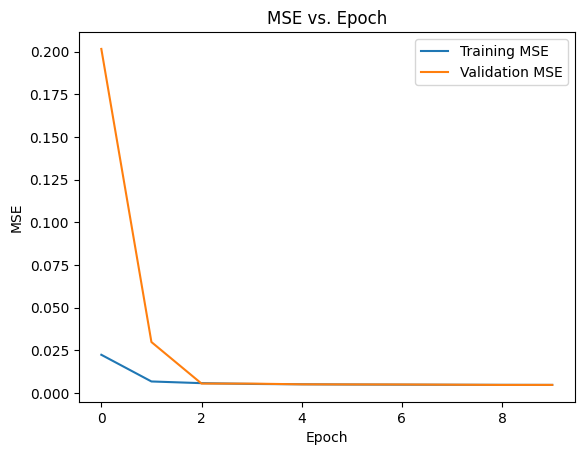

In [57]:
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs. Epoch')
plt.legend()
plt.show()

# MIN LOSS = 0.0128 c/fund 50epochs MSE
##         = 0.0118 s/fund 50epochs MSE
##         = 0.0039 s/fund 50epochs MSE m=4 d=6

In [58]:
# Assuming you have a validation dataset (val_dataset)
sample = next(iter(val_dataset))
input_data = sample[0]  # Assuming your dataset provides input data as the first element
actual_values = sample[1]  # Assuming your dataset provides actual labels as the second element

# Predict using the model
predictions = model.predict(input_data)

160/160 [==============================] - 1s 2ms/step


In [59]:
m_size = basis.size
rho_1_pred = []
rho_1_actual = []
norm = []
norm_rand = []
printear =  False

for e in val_dataset:
    for i in range(0, 3 if printear else batch_size):
        # Valores actuales
        #h = e[1][i].numpy().reshape(basis.size,basis.size)
        h_true = gen_to_h(e[1][i], rho_1_arrays)
        #print(h) if printear else 0
        r = max(np.linalg.eigvals(e[0][0][i]))
        rho_1_actual.append(r)

        print(h_true) if printear else 0
        print(r) if printear else 0

        # Valores predichos
        #h = predictions[i].reshape(basis.size,basis.size)
        h_pred = gen_to_h(predictions[i], rho_1_arrays)
        beta = 1
        state = thermal_state(h_pred, beta)
        rho1 = np.array(rho_1(basis.d, state, rho_1_arrays))
        r = max(np.sort(linalg_d.eigvals(rho1).real))
        rho_1_pred.append(r)

        print(h_pred) if printear else 0
        print(r) if printear else 0
        

        # Normas
        norm.append(np.linalg.norm(h_true-h_pred, ord='fro'))
        print(f'Norma {norm[-1]}') if printear else 0
        ## Vamos a comparar con un h aleatorio
        size = basis.d*(basis.d+1)//2
        base = np.random.uniform(low=0, high=1.0, size=(size,))
        h_rand = gen_to_h(base, rho_1_arrays)
        norm_rand.append(np.linalg.norm(h_true-h_rand, ord='fro'))
        #print(f'Norma random {norm_rand[-1]}') if printear else 0
        print('') if printear else 0
        


    # e contiene todo el batch y nos basta con uno
    break

Rho1 based statistics
0.0062954663
0.9164358377456665
std
0.008126121014356613
0.07604405283927917
0.0776832178235054


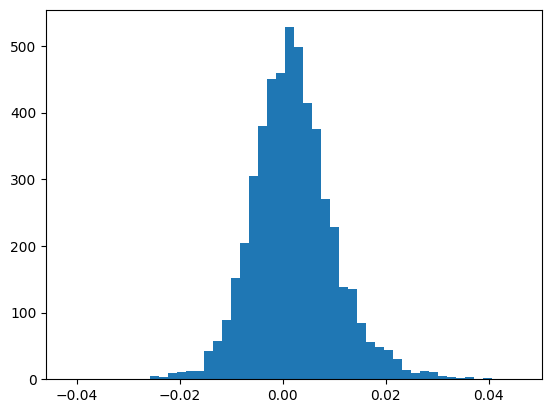

H based statistics
0.8770712 3.8083527


In [60]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

f=1
rho_1_actual = np.array(rho_1_actual)
rho_1_pred = np.array(rho_1_pred)
#print(mean_squared_error(rho_1_pred, rho_1_actual))

print('Rho1 based statistics')
print(np.mean(np.abs(rho_1_actual-rho_1_pred)))
print(np.mean(rho_1_actual)*f)
print('std')
print(np.std(rho_1_actual-rho_1_pred)*f)
print(np.std(rho_1_actual)*f)
print(np.std(rho_1_pred)*f)
plt.hist(np.array(rho_1_pred-rho_1_actual), bins=50)
plt.show()
print('H based statistics')
print(np.mean(norm), np.mean(norm_rand))


# BEST: FACTOR 1/8 c/fund
## 500 epochs, 10M dataset
# BEST: FACTOR 1/9 s/fund
## 50 epochs, 5M dataset

In [63]:
3.8/0.877

4.3329532497149374

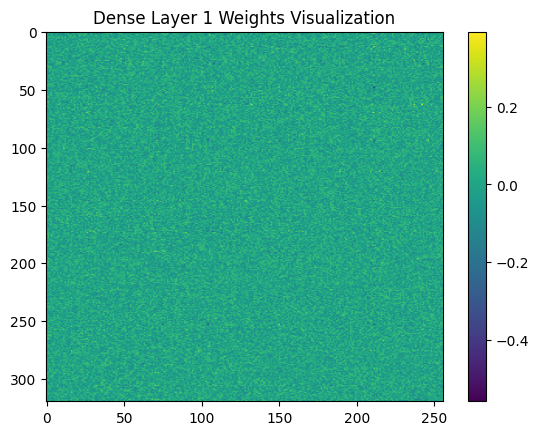

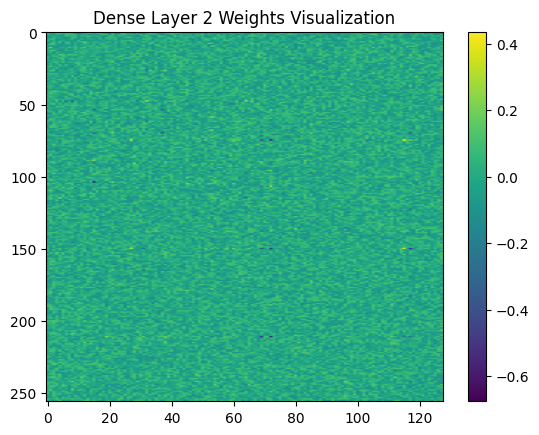

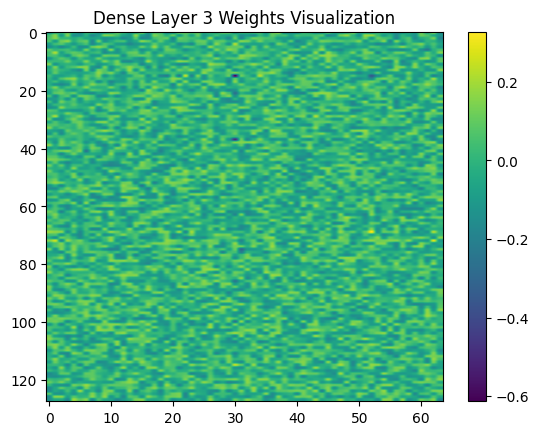

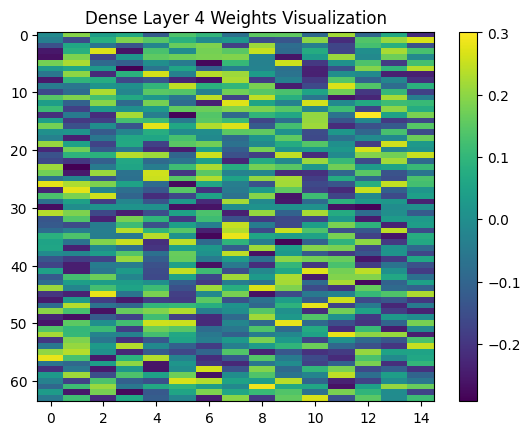

In [62]:
# Get the weights of all dense layers in the model
dense_weights = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        weights = layer.get_weights()
        if len(weights) > 0:
            dense_weights.append(weights[0])

# Visualize the weights of each dense layer
for i, weights in enumerate(dense_weights):
    plt.figure()
    plt.imshow(weights, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Dense Layer {i+1} Weights Visualization")
    plt.show()
